In [71]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [72]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


### Load functions

In [73]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [74]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [75]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [76]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [77]:
timeRange = [8005, 8017]

In [78]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

In [79]:
filesToLoad='0800[5-9].nc'
truth=loadOverlappedNetcdf(hisTruthFilePath,prefixTruth,filestring=filesToLoad,overlapDays=7)
OSSE_SSHSST=loadOSSE(hisOSSEFilePath1,prefixAnalysis, filestring=filesToLoad,overlapDays=7)
OSSE_SSHSST_XBT=loadOSSE(hisOSSEFilePath2,prefixAnalysis, filestring=filesToLoad,overlapDays=7)
OSSE_SSHSST_XBT_N=loadOSSE(hisOSSEFilePath3,prefixAnalysis, filestring=filesToLoad,overlapDays=7)
OSSE_SSHSST_XBT_S=loadOSSE(hisOSSEFilePath4,prefixAnalysis, filestring=filesToLoad,overlapDays=7)

loaded from /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08005.nc to /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08009.nc
loaded from /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08005.nc to /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08009.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08009.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08009.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/roms_fwd_outer1_08009.nc


In [80]:
# process into more useful format
truth = processROMSGrid(truth)
OSSE_SSHSST=processROMSGrid(OSSE_SSHSST)
OSSE_SSHSST_XBT=processROMSGrid(OSSE_SSHSST_XBT)
OSSE_SSHSST_XBT_N=processROMSGrid(OSSE_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S=processROMSGrid(OSSE_SSHSST_XBT_S)

In [81]:
grid = makeROMSGridObject(truth)

In [82]:
# ## define

# def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax


# # def spatialMap_test(toPlotData, gs, nrow, ncol):
# #     ax = fig.add_subplot(gs[nrow, ncol])
# #     ax.annotate('GridSpec[0, 1:]', xy=(0.5, 0.5),xycoords='axes fraction')
# #     return ax

# # gs = gridspec.GridSpec(nrows=2,ncols=4)
# # plt.cla()
# # plt.clf()
# # fig = plt.figure(figsize=[15,7])
# # ax = None

# # ax1 = spatialMap_test(OSSE_SSHSST.h,gs,0,0)
# # ax2 = spatialMap_test(OSSE_SSHSST.h,gs,0,1)
# # ax3 = spatialMap_test(OSSE_SSHSST.h,gs,1,0)
# # ax4 = spatialMap_test(OSSE_SSHSST.h,gs,1,1)

# # ax4.set_title('test')




# # gs to make a 4 row, 7 col plot
# gs = gridspec.GridSpec(nrows=5,ncols=5)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[15,22.5])
# ax = None

# # add plots
# ## top row
# ax1 = spatialMap_addGSSubplot(truth.u_eastward.mean(dim="s_rho").mean(dim="ocean_time"),gs,0,0,'a')#, ax1[0].set_title('u (m/s)')
# ax1.text(0.5, 1.1, 'u',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax1.transAxes)
# ax1.text(-.1, .5, 'mean state',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax1.transAxes)

# ax2 = spatialMap_addGSSubplot(truth.v_northward.mean(dim="s_rho").mean(dim="ocean_time"),gs,0,1,'b')#, ax2[0].set_title('v (m/s)')
# ax2.text(0.5, 1.1, 'v',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax2.transAxes)
# ax3 = spatialMap_addGSSubplot(truth.temp.isel(s_rho=-1).mean(dim="ocean_time"),gs,0,2,'c',pcol_kwargs={'cmap':'cmo.thermal'})#, ax3[0].set_title('SST ($\degree$C)')
# ax3.text(0.5, 1.1, 'SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax3.transAxes)
# ax4 = spatialMap_addGSSubplot(horizontalSectionROMS(grid, truth.temp, np.array([-500])).mean(dim='ocean_time'),gs,0,3,'d',pcol_kwargs={'cmap':'cmo.thermal'})
# ax4.text(0.5, 1.1, 'temp (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax4.transAxes)
# ax5 = spatialMap_addGSSubplot(truth.zeta.mean(dim="ocean_time"),gs,0,4,'e',pcol_kwargs={'cmap':'cmo.curl'})#, ax4[0].set_title('SSH ($\degree$C)')
# ax5.text(0.5, 1.1, 'SSH',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax5.transAxes)
# ## OSSE_SSHSST row
# ax6 = spatialMap_addGSSubplot(OSSE_SSHSST.u_eastward.mean(dim="s_rho").mean(dim="ocean_time"),gs,1,0,'f')
# ax6.text(-.1, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax6.transAxes)
# ax7 = spatialMap_addGSSubplot(OSSE_SSHSST.v_northward.mean(dim="s_rho").mean(dim="ocean_time"),gs,1,1,'g')
# ax8 = spatialMap_addGSSubplot(OSSE_SSHSST.temp.isel(s_rho=-1).mean(dim="ocean_time"),gs,1,2,'h',pcol_kwargs={'cmap':'cmo.thermal'})
# ax9 = spatialMap_addGSSubplot(horizontalSectionROMS(grid, OSSE_SSHSST.temp, np.array([-500])).mean(dim='ocean_time'),gs,1,3,'i',pcol_kwargs={'cmap':'cmo.thermal'})
# ax10 = spatialMap_addGSSubplot(OSSE_SSHSST.zeta.mean(dim="ocean_time"),gs,1,4,'j',pcol_kwargs={'cmap':'cmo.curl'})
# ## OSSE_SSHSST_XBT_N row
# ax6 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT_N.u_eastward.mean(dim="s_rho").mean(dim="ocean_time"),gs,2,0,'k')
# ax6.text(-.1, .5, 'SSH+SST+XBT_N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax6.transAxes)
# ax7 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT_N.v_northward.mean(dim="s_rho").mean(dim="ocean_time"),gs,2,1,'l')
# ax8 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT_N.temp.isel(s_rho=-1).mean(dim="ocean_time"),gs,2,2,'m',pcol_kwargs={'cmap':'cmo.thermal'})
# ax9 = spatialMap_addGSSubplot(horizontalSectionROMS(grid, OSSE_SSHSST_XBT_N.temp, np.array([-500])).mean(dim='ocean_time'),gs,2,3,'n',pcol_kwargs={'cmap':'cmo.thermal'})
# ax10 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT_N.zeta.mean(dim="ocean_time"),gs,2,4,'o',pcol_kwargs={'cmap':'cmo.curl'})
# ## OSSE_SSHSST_XBT_S row
# ax6 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT_S.u_eastward.mean(dim="s_rho").mean(dim="ocean_time"),gs,3,0,'p')
# ax6.text(-.1, .5, 'SSH+SST+XBT_S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax6.transAxes)
# ax7 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT_S.v_northward.mean(dim="s_rho").mean(dim="ocean_time"),gs,3,1,'q')
# ax8 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT_S.temp.isel(s_rho=-1).mean(dim="ocean_time"),gs,3,2,'r',pcol_kwargs={'cmap':'cmo.thermal'})
# ax9 = spatialMap_addGSSubplot(horizontalSectionROMS(grid, OSSE_SSHSST_XBT_S.temp, np.array([-500])).mean(dim='ocean_time'),gs,3,3,'s',pcol_kwargs={'cmap':'cmo.thermal'})
# ax10 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT_S.zeta.mean(dim="ocean_time"),gs,3,4,'t',pcol_kwargs={'cmap':'cmo.curl'})
# ## OSSE_SSHSST_XBT row
# ax6 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT.u_eastward.mean(dim="s_rho").mean(dim="ocean_time"),gs,4,0,'u')
# ax6.text(-.1, .5, 'SSH+SST+XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax6.transAxes)
# ax7 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT.v_northward.mean(dim="s_rho").mean(dim="ocean_time"),gs,4,1,'v')
# ax8 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT.temp.isel(s_rho=-1).mean(dim="ocean_time"),gs,4,2,'w',pcol_kwargs={'cmap':'cmo.thermal'})
# ax9 = spatialMap_addGSSubplot(horizontalSectionROMS(grid, OSSE_SSHSST_XBT.temp, np.array([-500])).mean(dim='ocean_time'),gs,4,3,'x',pcol_kwargs={'cmap':'cmo.thermal'})
# ax10 = spatialMap_addGSSubplot(OSSE_SSHSST_XBT.zeta.mean(dim="ocean_time"),gs,4,4,'y',pcol_kwargs={'cmap':'cmo.curl'})



In [83]:
# ## define

# def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax


# # def spatialMap_test(toPlotData, gs, nrow, ncol):
# #     ax = fig.add_subplot(gs[nrow, ncol])
# #     ax.annotate('GridSpec[0, 1:]', xy=(0.5, 0.5),xycoords='axes fraction')
# #     return ax

# # gs = gridspec.GridSpec(nrows=2,ncols=4)
# # plt.cla()
# # plt.clf()
# # fig = plt.figure(figsize=[15,7])
# # ax = None

# # ax1 = spatialMap_test(OSSE_SSHSST.h,gs,0,0)
# # ax2 = spatialMap_test(OSSE_SSHSST.h,gs,0,1)
# # ax3 = spatialMap_test(OSSE_SSHSST.h,gs,1,0)
# # ax4 = spatialMap_test(OSSE_SSHSST.h,gs,1,1)

# # ax4.set_title('test')




# # gs to make a 4 row, 7 col plot
# gs = gridspec.GridSpec(nrows=5,ncols=4)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[15,22.5])
# ax = None

# # add plots
# ## top row
# ax1 = spatialMap_addGSSubplot(truth.u_eastward.mean(dim="s_rho").mean(dim="ocean_time"),gs,0,0,'a')#, ax1[0].set_title('u (m/s)')
# ax2 = spatialMap_addGSSubplot(truth.v_northward.mean(dim="s_rho").mean(dim="ocean_time"),gs,0,1,'b')#, ax2[0].set_title('v (m/s)')
# ax3 = spatialMap_addGSSubplot(truth.temp.isel(s_rho=-1).mean(dim="ocean_time"),gs,0,2,'c',pcol_kwargs={'cmap':'cmo.thermal'})#, ax3[0].set_title('SST ($\degree$C)')
# ax4 = spatialMap_addGSSubplot(truth.zeta.mean(dim="ocean_time"),gs,0,3,'d',pcol_kwargs={'cmap':'cmo.curl'})#, ax4[0].set_title('SSH ($\degree$C)')

# RMSD_SSHSST_TRUTH_u_east  = (((OSSE_SSHSST.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_TRUTH_v_north = (((OSSE_SSHSST.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_TRUTH_temp    = (((OSSE_SSHSST.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_TRUTH_zeta    = (((OSSE_SSHSST.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_N_TRUTH_u_east  = (((OSSE_SSHSST_XBT_N.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_v_north = (((OSSE_SSHSST_XBT_N.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_temp    = (((OSSE_SSHSST_XBT_N.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_zeta    = (((OSSE_SSHSST_XBT_N.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_S_TRUTH_u_east  = (((OSSE_SSHSST_XBT_S.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_v_north = (((OSSE_SSHSST_XBT_S.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_temp    = (((OSSE_SSHSST_XBT_S.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_zeta    = (((OSSE_SSHSST_XBT_S.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_TRUTH_u_east  = (((OSSE_SSHSST_XBT.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_v_north = (((OSSE_SSHSST_XBT.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_temp    = (((OSSE_SSHSST_XBT.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_zeta    = (((OSSE_SSHSST_XBT.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)


# ## OSSE_SSHSST row
# ax5 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_u_east ,gs,1,0,'e',)
# ax6 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_v_north,gs,1,1,'f',)
# ax7 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_temp   ,gs,1,2,'g',)
# ax8 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_zeta   ,gs,1,3,'h',)
# ## OSSE_SSHSST_XBT_N row
# ax5 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_N_TRUTH_u_east ,gs,2,0,'i',)
# ax6 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_N_TRUTH_v_north,gs,2,1,'j',)
# ax7 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_N_TRUTH_temp   ,gs,2,2,'k',)
# ax8 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_N_TRUTH_zeta   ,gs,2,3,'l',)
# ## OSSE_SSHSST_XBT_S row
# ax5 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_S_TRUTH_u_east ,gs,3,0,'m',)
# ax6 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_S_TRUTH_v_north,gs,3,1,'n',)
# ax7 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_S_TRUTH_temp   ,gs,3,2,'o',)
# ax8 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_S_TRUTH_zeta   ,gs,3,3,'p',)
# ## OSSE_SSHSST_XBT row
# ax5 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_TRUTH_u_east ,gs,4,0,'q',)
# ax6 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_TRUTH_v_north,gs,4,1,'r',)
# ax7 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_TRUTH_temp   ,gs,4,2,'s',)
# ax8 = spatialMap_addGSSubplot(RMSD_SSHSST_XBT_TRUTH_zeta   ,gs,4,3,'t',)

In [84]:
# ## define

# def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax


# # def spatialMap_test(toPlotData, gs, nrow, ncol):
# #     ax = fig.add_subplot(gs[nrow, ncol])
# #     ax.annotate('GridSpec[0, 1:]', xy=(0.5, 0.5),xycoords='axes fraction')
# #     return ax

# # gs = gridspec.GridSpec(nrows=2,ncols=4)
# # plt.cla()
# # plt.clf()
# # fig = plt.figure(figsize=[15,7])
# # ax = None

# # ax1 = spatialMap_test(OSSE_SSHSST.h,gs,0,0)
# # ax2 = spatialMap_test(OSSE_SSHSST.h,gs,0,1)
# # ax3 = spatialMap_test(OSSE_SSHSST.h,gs,1,0)
# # ax4 = spatialMap_test(OSSE_SSHSST.h,gs,1,1)

# # ax4.set_title('test')




# # gs to make a 4 row, 7 col plot
# gs = gridspec.GridSpec(nrows=5,ncols=5)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[15,22.5])
# ax = None

# # add plots
# ## top row
# # ax1 = spatialMap_addGSSubplot(truth.u_eastward.mean(dim="s_rho").mean(dim="ocean_time"),gs,0,0,'a')#, ax1[0].set_title('u (m/s)')
# # ax2 = spatialMap_addGSSubplot(truth.v_northward.mean(dim="s_rho").mean(dim="ocean_time"),gs,0,1,'b')#, ax2[0].set_title('v (m/s)')
# # ax3 = spatialMap_addGSSubplot(truth.temp.isel(s_rho=-1).mean(dim="ocean_time"),gs,0,2,'c',pcol_kwargs={'cmap':'cmo.thermal'})#, ax3[0].set_title('SST ($\degree$C)')
# # ax4 = spatialMap_addGSSubplot(truth.zeta.mean(dim="ocean_time"),gs,0,3,'d',pcol_kwargs={'cmap':'cmo.curl'})#, ax4[0].set_title('SSH ($\degree$C)')

# RMSD_SSHSST_TRUTH_u_east  = (((OSSE_SSHSST.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_TRUTH_v_north = (((OSSE_SSHSST.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_TRUTH_temp    = (((OSSE_SSHSST.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_TRUTH_zeta    = (((OSSE_SSHSST.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_N_TRUTH_u_east  = (((OSSE_SSHSST_XBT_N.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_v_north = (((OSSE_SSHSST_XBT_N.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_temp    = (((OSSE_SSHSST_XBT_N.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_N.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_zeta    = (((OSSE_SSHSST_XBT_N.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_S_TRUTH_u_east  = (((OSSE_SSHSST_XBT_S.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_v_north = (((OSSE_SSHSST_XBT_S.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_temp    = (((OSSE_SSHSST_XBT_S.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_S.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_zeta    = (((OSSE_SSHSST_XBT_S.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_TRUTH_u_east  = (((OSSE_SSHSST_XBT.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_v_north = (((OSSE_SSHSST_XBT.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_temp    = (((OSSE_SSHSST_XBT.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_zeta    = (((OSSE_SSHSST_XBT.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# I_XBT_N_u       = (RMSD_SSHSST_TRUTH_u_east - RMSD_SSHSST_XBT_N_TRUTH_u_east)/RMSD_SSHSST_TRUTH_u_east*100
# I_XBT_N_v       = (RMSD_SSHSST_TRUTH_v_north - RMSD_SSHSST_XBT_N_TRUTH_v_north)/RMSD_SSHSST_TRUTH_v_north*100
# I_XBT_N_temp    = (RMSD_SSHSST_TRUTH_temp - RMSD_SSHSST_XBT_N_TRUTH_temp)/RMSD_SSHSST_TRUTH_temp*100
# I_XBT_N_temp500 = (RMSD_SSHSST_TRUTH_temp500 - RMSD_SSHSST_XBT_N_TRUTH_temp500)/RMSD_SSHSST_TRUTH_temp500*100
# I_XBT_N_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_N_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100

# I_XBT_S_u       = (RMSD_SSHSST_TRUTH_u_east - RMSD_SSHSST_XBT_S_TRUTH_u_east)/RMSD_SSHSST_TRUTH_u_east*100
# I_XBT_S_v       = (RMSD_SSHSST_TRUTH_v_north - RMSD_SSHSST_XBT_S_TRUTH_v_north)/RMSD_SSHSST_TRUTH_v_north*100
# I_XBT_S_temp    = (RMSD_SSHSST_TRUTH_temp - RMSD_SSHSST_XBT_S_TRUTH_temp)/RMSD_SSHSST_TRUTH_temp*100
# I_XBT_S_temp500 = (RMSD_SSHSST_TRUTH_temp500 - RMSD_SSHSST_XBT_S_TRUTH_temp500)/RMSD_SSHSST_TRUTH_temp500*100
# I_XBT_S_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_S_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100

# I_XBT_u       = (RMSD_SSHSST_TRUTH_u_east - RMSD_SSHSST_XBT_S_TRUTH_u_east)/RMSD_SSHSST_TRUTH_u_east*100
# I_XBT_v       = (RMSD_SSHSST_TRUTH_v_north - RMSD_SSHSST_XBT_TRUTH_v_north)/RMSD_SSHSST_TRUTH_v_north*100
# I_XBT_temp    = (RMSD_SSHSST_TRUTH_temp - RMSD_SSHSST_XBT_TRUTH_temp)/RMSD_SSHSST_TRUTH_temp*100
# I_XBT_temp500 = (RMSD_SSHSST_TRUTH_temp500 - RMSD_SSHSST_XBT_TRUTH_temp500)/RMSD_SSHSST_TRUTH_temp500*100
# I_XBT_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100

# ## OSSE_SSHSST row
# ax5 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_u_east ,gs,0,0,'e',)
# ax5.text(0.5, 1.1, 'u',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax5.transAxes)
# ax5.text(-.1, .5, 'SSH+SST RMSD',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax6 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_v_north,gs,0,1,'f',)
# ax6.text(0.5, 1.1, 'v',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax6.transAxes)
# ax7 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_temp   ,gs,0,2,'g',)
# ax7.text(0.5, 1.1, 'SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_temp500   ,gs,0,3,'g',)
# ax7.text(0.5, 1.1, 'temp (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax8 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_zeta   ,gs,0,4,'h',)
# ax8.text(0.5, 1.1, 'SSH',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)
# ## OSSE_SSHSST_XBT_N row
# ax5 = spatialMap_addGSSubplot(I_XBT_N_u      ,gs,1,0,'i',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax5.text(-.1, .5, 'SSH+SST+XBT_N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax6 = spatialMap_addGSSubplot(I_XBT_N_v      ,gs,1,1,'j',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax7 = spatialMap_addGSSubplot(I_XBT_N_temp   ,gs,1,2,'k',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax7 = spatialMap_addGSSubplot(I_XBT_N_temp500,gs,1,3,'k',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax8 = spatialMap_addGSSubplot(I_XBT_N_zeta   ,gs,1,4,'l',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ## OSSE_SSHSST_XBT_S row
# ax5 = spatialMap_addGSSubplot(I_XBT_S_u      ,gs,2,0,'m',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax5.text(-.1, .5, 'SSH+SST+XBT_S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax6 = spatialMap_addGSSubplot(I_XBT_S_v      ,gs,2,1,'n',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax7 = spatialMap_addGSSubplot(I_XBT_S_temp   ,gs,2,2,'o',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax7 = spatialMap_addGSSubplot(I_XBT_S_temp500,gs,2,3,'o',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax8 = spatialMap_addGSSubplot(I_XBT_S_zeta   ,gs,2,4,'p',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ## OSSE_SSHSST_XBT row
# ax5 = spatialMap_addGSSubplot(I_XBT_u      ,gs,3,0,'q',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax5.text(-.1, .5, 'SSH+SST+XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax6 = spatialMap_addGSSubplot(I_XBT_v      ,gs,3,1,'r',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax7 = spatialMap_addGSSubplot(I_XBT_temp   ,gs,3,2,'s',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax7 = spatialMap_addGSSubplot(I_XBT_temp500,gs,3,3,'s',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})
# ax8 = spatialMap_addGSSubplot(I_XBT_zeta   ,gs,3,4,'t',pcol_kwargs={'cmap':'cmo.rain','vmin':0,'vmax':100})


## mean metric analysis

In [98]:
# calculate RMS for SSH, SST WHOLE DOMAIN

# def calc_rmseSpatial(input1,input2,etaRange,xiRange):
#     err2 = (input1-input2)**2
#     # err=err2**(1/2)
#     mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
#     output = mse**(1/2)
#     return mse,output

# # define function for calculating spatial mean
# def indexMeanMetric(input,etaRange,xiRange):
#     ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
#     output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
#     return output
etaSelect=[0, 315]
xiSelect=[0, 270]
err, RMS_SSHSST_SSH = calc_rmseSpatial(OSSE_SSHSST.zeta,truth.zeta,etaRange=etaSelect,xiRange=xiSelect)

RMSD_SSHSST_TRUTH_zeta    = (((OSSE_SSHSST.zeta-truth.zeta)**2).isel(eta_rho=slice(etaSelect[0],etaSelect[1]),xi_rho=slice(xiSelect[0],xiSelect[1]),drop=True).mean(dim="eta_rho", skipna=True).mean(dim="xi_rho", skipna=True))**(1/2)

Ana_Truth = np.sqrt(np.nanmean(np.nanmean((OSSE_SSHSST.zeta-truth.zeta)**2,axis=2),axis=1))


In [132]:
np.sqrt(np.nanmean(np.nanmean(((OSSE_SSHSST.zeta.values-truth.zeta.values)**2),axis=2),axis=1))#.mean(dim='xi_rho').mean(dim='eta_rho').values

array([0.10947632, 0.09963413, 0.09587581, 0.09084887, 0.08862884,
       0.08976315, 0.08874797, 0.08702425, 0.08593581, 0.08672968,
       0.08725509, 0.08648638, 0.0843283 , 0.0834903 , 0.08411727,
       0.08419775, 0.08379075, 0.08339024, 0.08310866, 0.08211731,
       0.08180166, 0.08294776, 0.08335961, 0.08225591, 0.08179874,
       0.07593231, 0.07530581, 0.07414476, 0.07088002, 0.06859638,
       0.06869678, 0.06981371, 0.07015529, 0.06968856, 0.07017558,
       0.07108171, 0.07167079, 0.07210558, 0.07273161, 0.07381844,
       0.07536826, 0.07591241, 0.07651094, 0.07742565, 0.07794655,
       0.07829601, 0.07834147, 0.0792482 ])

In [149]:
OSSE_SSHSST.zeta.shape

(48, 317, 272)

In [159]:
((OSSE_SSHSST.zeta-truth.zeta)**2).mean(dim="xi_rho").mean(dim="eta_rho").values

array([0.01198507, 0.00992696, 0.00919217, 0.00825352, 0.00785507,
       0.00805742, 0.0078762 , 0.00757322, 0.00738496, 0.00752204,
       0.00761345, 0.00747989, 0.00711126, 0.00697063, 0.00707571,
       0.00708926, 0.00702089, 0.00695393, 0.00690705, 0.00674325,
       0.00669151, 0.00688033, 0.00694882, 0.00676603, 0.00669103,
       0.00576572, 0.00567097, 0.00549745, 0.00502398, 0.00470546,
       0.00471925, 0.00487395, 0.00492176, 0.0048565 , 0.00492461,
       0.00505261, 0.0051367 , 0.00519922, 0.00528989, 0.00544916,
       0.00568038, 0.00576269, 0.00585392, 0.00599473, 0.00607567,
       0.00613026, 0.00613739, 0.00628028])

In [217]:
test_tog=((OSSE_SSHSST.zeta-truth.zeta)**2).mean(dim=["eta_rho","xi_rho"]).values

In [161]:
((OSSE_SSHSST.zeta-truth.zeta)**2).mean(dim="eta_rho").mean(dim="xi_rho").values

array([0.00993957, 0.01114974, 0.00785932, 0.00731974, 0.00636228,
       0.00638848, 0.00649439, 0.00610497, 0.00644544, 0.00673528,
       0.00603254, 0.00602366, 0.00569868, 0.00546692, 0.00552064,
       0.00567553, 0.00557833, 0.00544793, 0.00549494, 0.00548478,
       0.00563203, 0.00578748, 0.00574351, 0.00553221, 0.00549329,
       0.00572107, 0.00521747, 0.00492164, 0.0042493 , 0.00386385,
       0.00375869, 0.00383545, 0.00389843, 0.00388094, 0.00392914,
       0.00399663, 0.0040856 , 0.00419799, 0.00430076, 0.00435092,
       0.00449385, 0.00458116, 0.0047252 , 0.00487284, 0.00493273,
       0.00498445, 0.00500265, 0.00506771])

In [115]:
Ana_Truth

array([0.10947632, 0.09963413, 0.09587581, 0.09084887, 0.08862884,
       0.08976315, 0.08874797, 0.08702425, 0.08593581, 0.08672968,
       0.08725509, 0.08648638, 0.0843283 , 0.0834903 , 0.08411727,
       0.08419775, 0.08379075, 0.08339024, 0.08310866, 0.08211731,
       0.08180166, 0.08294776, 0.08335961, 0.08225591, 0.08179874,
       0.07593231, 0.07530581, 0.07414476, 0.07088002, 0.06859638,
       0.06869678, 0.06981371, 0.07015529, 0.06968856, 0.07017558,
       0.07108171, 0.07167079, 0.07210558, 0.07273161, 0.07381844,
       0.07536826, 0.07591241, 0.07651094, 0.07742565, 0.07794655,
       0.07829601, 0.07834147, 0.0792482 ])

In [175]:
((OSSE_SSHSST.zeta[0,:,:]-truth.zeta[0,:,:])**2)

<xarray.DataArray 'zeta' (eta_rho: 317, xi_rho: 272)>
dask.array<pow, shape=(317, 272), dtype=float64, chunksize=(317, 272), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
    ocean_time  datetime64[ns] 2011-12-02
Dimensions without coordinates: eta_rho, xi_rho

In [215]:
test=(OSSE_SSHSST.zeta-truth.zeta)**2

test2 = (test*OSSE_SSHSST.dy*OSSE_SSHSST.dx).sum(dim=['eta_rho','xi_rho'],skipna=True)/(OSSE_SSHSST.dy*OSSE_SSHSST.dx).sum(dim=['eta_rho','xi_rho'],skipna=True)
(test2**(1/2)).values
# test = (OSSE_SSHSST.zeta*OSSE_SSHSST.dy*OSSE_SSHSST.dx).sum(('eta_rho','xi_rho'))/(OSSE_SSHSST.dy*OSSE_SSHSST.dx).sum(('eta_rho','xi_rho'))


array([0.09359209, 0.08394901, 0.08169768, 0.07852022, 0.0768071 ,
       0.07757684, 0.07669866, 0.07530298, 0.07465518, 0.07526303,
       0.07539788, 0.0747957 , 0.07313568, 0.07255317, 0.07318136,
       0.07335134, 0.07297767, 0.07244273, 0.07213314, 0.07143473,
       0.0710859 , 0.07181972, 0.07208802, 0.07119723, 0.07063973,
       0.06374161, 0.06323463, 0.06230463, 0.06007619, 0.05823767,
       0.05843434, 0.05911829, 0.05923928, 0.05866703, 0.05910493,
       0.05988548, 0.06030666, 0.06046075, 0.06092632, 0.06193387,
       0.06339721, 0.0637442 , 0.06401177, 0.06460521, 0.06510205,
       0.0655776 , 0.065701  , 0.06637953])

In [209]:
OSSE_SSHSST.zeta[19,199,199].values

array(0.85601413)

In [206]:
test = (OSSE_SSHSST.zeta*OSSE_SSHSST.dy*OSSE_SSHSST.dx).sum(dim=['eta_rho','xi_rho'],skipna=True)/(OSSE_SSHSST.dy*OSSE_SSHSST.dx).sum(dim=['eta_rho','xi_rho'],skipna=True)
test.values

array([0.28790696, 0.29171529, 0.29313287, 0.29364806, 0.29617377,
       0.29639411, 0.29583686, 0.29602572, 0.29831913, 0.3020877 ,
       0.30177238, 0.30043515, 0.30003221, 0.30326051, 0.30694113,
       0.3095896 , 0.30737972, 0.30411104, 0.30172788, 0.30073658,
       0.29888975, 0.2964307 , 0.298413  , 0.30113408, 0.30217708,
       0.29382347, 0.29195863, 0.29301714, 0.29562905, 0.29868737,
       0.30082253, 0.3023167 , 0.30322258, 0.30289062, 0.30324364,
       0.30387922, 0.30419156, 0.30450534, 0.30490701, 0.30502382,
       0.30633439, 0.30625579, 0.30546479, 0.30210955, 0.29748727,
       0.2966427 , 0.29788527, 0.29982197])

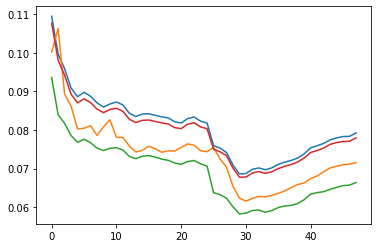

In [219]:
fig, ax = plt.subplots()
ax.plot(Ana_Truth)
ax.plot(RMS_SSHSST_SSH)
ax.plot(test2**(1/2))
ax.plot(test_tog**(1/2))

In [214]:
test = (OSSE_SSHSST.zeta*OSSE_SSHSST.dy*OSSE_SSHSST.dx).sum(('eta_rho','xi_rho'))/(OSSE_SSHSST.dy*OSSE_SSHSST.dx).sum(('eta_rho','xi_rho'))

(test).values





array([0.28790696, 0.29171529, 0.29313287, 0.29364806, 0.29617377,
       0.29639411, 0.29583686, 0.29602572, 0.29831913, 0.3020877 ,
       0.30177238, 0.30043515, 0.30003221, 0.30326051, 0.30694113,
       0.3095896 , 0.30737972, 0.30411104, 0.30172788, 0.30073658,
       0.29888975, 0.2964307 , 0.298413  , 0.30113408, 0.30217708,
       0.29382347, 0.29195863, 0.29301714, 0.29562905, 0.29868737,
       0.30082253, 0.3023167 , 0.30322258, 0.30289062, 0.30324364,
       0.30387922, 0.30419156, 0.30450534, 0.30490701, 0.30502382,
       0.30633439, 0.30625579, 0.30546479, 0.30210955, 0.29748727,
       0.2966427 , 0.29788527, 0.29982197])

In [ ]:
### Now same but for 'upstream' area

etaRangeMetric = [0, 315] #[115, 200]
xiRangeMetric = [0, 270] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
ax.plot(lon_N,lat_N,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
ax.plot(lon_S,lat_S,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))



ssh_metricTruth, sst_metricTruth = compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist)

ssh_metricForecast1,ssh_metricAnalysis1 = compileOSSETimeMetricSSH(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast2,ssh_metricAnalysis2 = compileOSSETimeMetricSSH(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast3,ssh_metricAnalysis3 = compileOSSETimeMetricSSH(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast4,ssh_metricAnalysis4 = compileOSSETimeMetricSSH(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    

sst_metricForecast1,sst_metricAnalysis1 = compileOSSETimeMetricSST(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast2,sst_metricAnalysis2 = compileOSSETimeMetricSST(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast3,sst_metricAnalysis3 = compileOSSETimeMetricSST(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast4,sst_metricAnalysis4 = compileOSSETimeMetricSST(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    


fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
ssh_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

ssh_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle=      'dashed' )
ssh_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle=  'dashed' )
ssh_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
ssh_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

ssh_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle=      'solid')
ssh_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle=  'solid')
ssh_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
ssh_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    ssh_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    ssh_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    ssh_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    ssh_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    ssh_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    ssh_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    ssh_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    ssh_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    ssh_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
sst_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

sst_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle='dashed')
sst_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle='dashed')
sst_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
sst_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

sst_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle='solid')
sst_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle='solid')
sst_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
sst_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    sst_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    sst_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    sst_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    sst_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    sst_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    sst_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    sst_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    sst_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    sst_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

In [ ]:
etaRangeMetric = [270, 310] #[115, 200]
xiRangeMetric = [75, 175] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
ax.plot(lon_N,lat_N,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
ax.plot(lon_S,lat_S,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))



ssh_metricTruth, sst_metricTruth = compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist)

ssh_metricForecast1,ssh_metricAnalysis1 = compileOSSETimeMetricSSH(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast2,ssh_metricAnalysis2 = compileOSSETimeMetricSSH(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast3,ssh_metricAnalysis3 = compileOSSETimeMetricSSH(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast4,ssh_metricAnalysis4 = compileOSSETimeMetricSSH(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    

sst_metricForecast1,sst_metricAnalysis1 = compileOSSETimeMetricSST(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast2,sst_metricAnalysis2 = compileOSSETimeMetricSST(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast3,sst_metricAnalysis3 = compileOSSETimeMetricSST(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast4,sst_metricAnalysis4 = compileOSSETimeMetricSST(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    


fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
ssh_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

ssh_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle=      'dashed' )
ssh_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle=  'dashed' )
ssh_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
ssh_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

ssh_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle=      'solid')
ssh_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle=  'solid')
ssh_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
ssh_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    ssh_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    ssh_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    ssh_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    ssh_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    ssh_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    ssh_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    ssh_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    ssh_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    ssh_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
sst_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

sst_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle='dashed')
sst_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle='dashed')
sst_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
sst_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

sst_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle='solid')
sst_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle='solid')
sst_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
sst_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    sst_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    sst_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    sst_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    sst_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    sst_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    sst_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    sst_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    sst_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    sst_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

In [ ]:
etaRangeMetric = [70, 185] #[115, 200]
xiRangeMetric = [105, 185] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
ax.plot(lon_N,lat_N,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
ax.plot(lon_S,lat_S,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))



ssh_metricTruth, sst_metricTruth = compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist)

ssh_metricForecast1,ssh_metricAnalysis1 = compileOSSETimeMetricSSH(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast2,ssh_metricAnalysis2 = compileOSSETimeMetricSSH(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast3,ssh_metricAnalysis3 = compileOSSETimeMetricSSH(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast4,ssh_metricAnalysis4 = compileOSSETimeMetricSSH(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    

sst_metricForecast1,sst_metricAnalysis1 = compileOSSETimeMetricSST(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast2,sst_metricAnalysis2 = compileOSSETimeMetricSST(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast3,sst_metricAnalysis3 = compileOSSETimeMetricSST(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast4,sst_metricAnalysis4 = compileOSSETimeMetricSST(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    


fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
ssh_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

ssh_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle=      'dashed' )
ssh_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle=  'dashed' )
ssh_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
ssh_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

ssh_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle=      'solid')
ssh_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle=  'solid')
ssh_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
ssh_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    ssh_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    ssh_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    ssh_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    ssh_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    ssh_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    ssh_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    ssh_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    ssh_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    ssh_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
sst_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

sst_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle='dashed')
sst_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle='dashed')
sst_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
sst_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

sst_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle='solid')
sst_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle='solid')
sst_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
sst_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    sst_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    sst_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    sst_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    sst_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    sst_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    sst_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    sst_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    sst_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    sst_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

## RMS overview

In [ ]:

datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

fig, ax = plt.subplots(1,figsize=(10,5))

for dates in datelist:
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    filenameForecast1=hisOSSEFilePath1+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis1=hisOSSEFilePath1+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameForecast2=hisOSSEFilePath2+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis2=hisOSSEFilePath2+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameForecast3=hisOSSEFilePath3+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis3=hisOSSEFilePath3+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameForecast4=hisOSSEFilePath4+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis4=hisOSSEFilePath4+prefixAnalysis+'0'+str(dates)+'.nc'

    sshForecast1=xr.open_dataset(filenameForecast1).zeta.load()
    sshAnalysis1=xr.open_dataset(filenameAnalysis1).zeta.load()
    sshForecast2=xr.open_dataset(filenameForecast2).zeta.load()
    sshAnalysis2=xr.open_dataset(filenameAnalysis2).zeta.load()
    sshForecast3=xr.open_dataset(filenameForecast3).zeta.load()
    sshAnalysis3=xr.open_dataset(filenameAnalysis3).zeta.load()
    sshForecast4=xr.open_dataset(filenameForecast4).zeta.load()
    sshAnalysis4=xr.open_dataset(filenameAnalysis4).zeta.load()
    
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    Ana1_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis1-sshTruth)**2,axis=2),axis=1))
    Fore1_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast1-sshTruth)**2,axis=2),axis=1))
    Ana2_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis2-sshTruth)**2,axis=2),axis=1))
    Fore2_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast2-sshTruth)**2,axis=2),axis=1))
    Ana3_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis3-sshTruth)**2,axis=2),axis=1))
    Fore3_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast3-sshTruth)**2,axis=2),axis=1))
    Ana4_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis4-sshTruth)**2,axis=2),axis=1))
    Fore4_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast4-sshTruth)**2,axis=2),axis=1))
    
#     Ana_Fore = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshForecast)**2,axis=2),axis=1))
    time = sshForecast1.ocean_time.values
    if dates == datelist[0]:
        ax.plot(time, Fore1_Truth, color="C1",label='RMS Forecast-Truth SSH+SST',linestyle='dashed')
        ax.plot(time, Ana1_Truth, color="C1",label='RMS Analysis-Truth SSH+SST')
        ax.plot(time, Fore2_Truth, color="C2",label='RMS Forecast-Truth SSH+SST+XBT',linestyle='dashed')
        ax.plot(time, Ana2_Truth, color="C2",label='RMS Analysis-Truth SSH+SST+XBT')
        ax.plot(time, Fore3_Truth, color="C3",label='RMS Forecast-Truth SSH+SST+XBT_N',linestyle='dashed')
        ax.plot(time, Ana3_Truth, color="C3",label='RMS Analysis-Truth SSH+SST+XBT_N')
        ax.plot(time, Fore4_Truth, color="C4",label='RMS Forecast-Truth SSH+SST+XBT_S',linestyle='dashed')
        ax.plot(time, Ana4_Truth, color="C4",label='RMS Analysis-Truth SSH+SST+XBT_S')
    elif dates != datelist[0]:
        ax.plot(time, Fore1_Truth, color="C1",label='_nolegend_',linestyle='dashed')
        ax.plot(time, Ana1_Truth, color="C1",label='_nolegend_')
        ax.plot(time, Fore2_Truth, color="C2",label='_nolegend_',linestyle='dashed')
        ax.plot(time, Ana2_Truth, color="C2",label='_nolegend_')
        ax.plot(time, Fore3_Truth, color="C3",label='_nolegend_',linestyle='dashed')
        ax.plot(time, Ana3_Truth, color="C3",label='_nolegend_')
        ax.plot(time, Fore4_Truth, color="C4",label='_nolegend_',linestyle='dashed')
        ax.plot(time, Ana4_Truth, color="C4",label='_nolegend_')
        
#     ax.plot(time, Ana_Fore, color="C2",label='Truth')
ax.legend()
ax.grid()
ax.tick_params('x',labelrotation=45)


In [ ]:
timePeriod = 4  #days
timeOutputs = 1 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

rr=0
timeVec = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHobs = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHmod = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHanal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHfore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSHerror_fore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSHerror_anal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHtruth = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHfore = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHanal = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()
    
    filenameObs=obsFinalFilePath+prefixObs+str(dates)+'.nc'
    obs=xr.open_dataset(filenameObs).load()

    for tChunk in range(0,timeOutputMax,timeOutputs):
        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2)
        # print(tChunk,time1,time2,time1sd,time2sd)
        timeVec[rr]=np.nanmean([time1sd,time2sd])

        modVal = mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        obsVal = obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        modAnal = mod.NLmodel_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        modFore = mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        meanSSHobs[rr] = np.nanmean(obsVal)
        meanSSHmod[rr] = np.nanmean(obsVal)
        meanSSHanal_obsspace[rr] = np.nanmean(modAnal)
        meanSSHfore_obsspace[rr] = np.nanmean(modFore)
        rmsSSHerror_fore_obsspace[rr] = np.sqrt(((modFore - obsVal)**2).mean(dim='datum',skipna=True))
        rmsSSHerror_anal_obsspace[rr] = np.sqrt(((modAnal - obsVal)**2).mean(dim='datum',skipna=True))

        meanSSHtruth[rr] = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSHfore[rr]  = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSHanal[rr]  = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)

        rr=rr+1




In [ ]:

fig,ax = plt.subplots(1,figsize=(20,8))
ax.plot(timeVec,meanSSHtruth,linestyle='-',color="C0",label='mean SSH truth')
ax.plot(timeVec,meanSSHobs,linestyle='none',marker='o',color="C0",label='mean SSH obs')
ax.plot(timeVec,meanSSHanal,linestyle='-',color="C1",label='mean SSH analysis')
ax.plot(timeVec,meanSSHanal_obsspace,linestyle='none',marker='o',color="C1",label='mean SSH obs analysis')
ax.plot(timeVec,meanSSHfore,linestyle='-',color="C2",label='mean SSH forecast')
ax.plot(timeVec,meanSSHfore_obsspace,linestyle='none',marker='o',color="C2",label='mean SSH obs forecast')
ax.grid()
ax.legend()
ax.set_ylim([.2,.5])

In [ ]:

fig,ax = plt.subplots(1,figsize=(20,8))
ax.plot(timeVec,meanSSHtruth,linestyle='-',color="C0",label='mean SSH truth')
ax.plot(timeVec,meanSSHanal,linestyle='-',color="C1",label='mean SSH analysis')
ax.plot(datelist,np.array(0.35*np.ones([len(datelist),1])),color='C4',linestyle='none',marker='o',markersize=3)
ax.vlines(datelist, ymin=0.25, ymax=.45, colors='green', ls=':', lw=1, label='cycle borders')
ax.grid()
ax.legend()
ax.set_ylim([.2,.5])
# ax.set_xlim([8080,8120])
ax.set_title('mean SSH for truth and analysis')

In [ ]:

fig, ax = plt.subplots(1,figsize=(20,8))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    Ana_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshTruth)**2,axis=2),axis=1))
    Fore_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast-sshTruth)**2,axis=2),axis=1))
    Ana_Fore = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshForecast)**2,axis=2),axis=1))
    time = sshForecast.ocean_time.values
    if dates == datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='RMS Forecast-Truth')
        ax.plot(time, Ana_Truth, color="C1",label='RMS Analysis-Truth')
        ax.vlines(time[0], ymin=0.05, ymax=.15, colors='green', ls=':', lw=1, label='cycle borders')
    elif dates != datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='_nolegend_')
        ax.plot(time, Ana_Truth, color="C1",label='_nolegend_')
        ax.vlines(time[0], ymin=0.05, ymax=.15, colors='green', ls=':', lw=1, label='_nolegend_')

ax.legend()
ax.grid()
ax.tick_params('x',labelrotation=45)
ax.set_xlim([serial_day_to_datestring(8080),serial_day_to_datestring(8120)])

In [ ]:

fig,ax = plt.subplots(1,figsize=(10,4))
ax.plot(timeVec,rmsSSHerror_anal_obsspace,linestyle='none',marker='o',color="C1",label='RMSe SSH Analysis-Truth',markersize=2)
ax.plot(timeVec,rmsSSHerror_fore_obsspace,linestyle='none',marker='o',color="C0",label='RMSe SSH Forecast-Truth',markersize=2)
ax.grid()
ax.legend()


In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=340

rr=0
timeVec = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTobs = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTmod = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTanal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTfore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSTerror_fore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSTerror_anal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTtruth = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTfore = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTanal = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()
    
    filenameObs=obsFinalFilePath+prefixObs+str(dates)+'.nc'
    obs=xr.open_dataset(filenameObs).load()

    for tChunk in range(0,timeOutputMax,timeOutputs):
        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2)
        # print(tChunk,time1,time2,time1sd,time2sd)
        timeVec[rr]=np.nanmean([time1sd,time2sd])

        modVal = mod.obs_value.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        obsVal = obs.obs_value.where(np.isnan(mod.obs_scale)==False).where((obs.obs_provenance==provValue) & (obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        modAnal = mod.NLmodel_value.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        modFore = mod.NLmodel_initial.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        meanSSTobs[rr] = np.nanmean(obsVal)
        meanSSTmod[rr] = np.nanmean(obsVal)
        meanSSTanal_obsspace[rr] = np.nanmean(modAnal)
        meanSSTfore_obsspace[rr] = np.nanmean(modFore)
        rmsSSTerror_fore_obsspace[rr] = np.sqrt(((modFore - obsVal)**2).mean(dim='datum',skipna=True))
        rmsSSTerror_anal_obsspace[rr] = np.sqrt(((modAnal - obsVal)**2).mean(dim='datum',skipna=True))

        meanSSTtruth[rr] = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSTfore[rr]  = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSTanal[rr]  = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)

        rr=rr+1




fig,ax = plt.subplots(1,figsize=(10,4))
ax.plot(timeVec,meanSSTtruth,linestyle='-',color="C0",label='mean SST truth')
ax.plot(timeVec,meanSSTobs,linestyle='none',marker='o',color="C0",label='mean SST obs')
ax.plot(timeVec,meanSSTanal,linestyle='-',color="C1",label='mean SST analysis')
ax.plot(timeVec,meanSSTanal_obsspace,linestyle='none',marker='o',color="C1",label='mean SST obs analysis')
ax.plot(timeVec,meanSSTfore,linestyle='-',color="C2",label='mean SST forecast')
ax.plot(timeVec,meanSSTfore_obsspace,linestyle='none',marker='o',color="C2",label='mean SST obs forecast')
ax.grid()
ax.legend()
# ax.set_ylim([.2,.5])

## now plot snapshots of fields

In [ ]:
timePeriod = 4  #days
timeOutputs = 6 # 4hrlymodel output * timeOutputs = hrs per snapshot. e.g. 3(*4hrs)=12hrly outputs, 6=24hrly output
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8033] 
datelist = np.array(range(timeRange[0],timeRange[1],4))
#datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=405

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    
    for tChunk in range(0,timeOutputMax,timeOutputs):
        fig, axes = plt.subplots(1,4, figsize=(16, 4), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        toPlotData = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[0]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([-1,1])
        ax.set_title('Truth')
        
        ax = axes[1]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        ax.set_title('Obs')
        
        toPlotData = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[2]            
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        im.set_clim([-1,1])
        ax.set_title('Forecast')


        toPlotData = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[3]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False  
        gl.left_labels = False
        im.set_clim([-1,1])
        ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        fig.colorbar(im, ax=axes.ravel().tolist())
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SSH Truth, Obs Forecast and Analysis, with observations, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('m')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=340

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    
    for tChunk in range(0,timeOutputMax,timeOutputs):
        fig, axes = plt.subplots(1,4, figsize=(16, 4), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[0]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([16,28])
        ax.set_title('Truth')
        
        ax = axes[1]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title('Obs')
        
        toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[2]            
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        im.set_clim([16,28])
        ax.set_title('Forecast')


        toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[3]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False  
        gl.left_labels = False
        im.set_clim([16,28])
        ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        fig.colorbar(im, ax=axes.ravel().tolist())
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Truth, Obs Forecast and Analysis, with observations, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=405

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-.5,.5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SSH Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('m')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    # sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    # sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-5,5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(1,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        ax = axes[rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')

        lo=obs.obs_lon.where(obs.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==True).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==True).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        sc2 = ax.plot(lo,la,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)

        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        rr=rr+1
        
        #date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        #date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+str(time1)[:-13]+' to '+str(time2)[:-13])
        plt.ylabel('degC')




In [ ]:
# mod.obs_value.where(np.isnan(mod.obs_scale)==False)
for dates in datelist:
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod = xr.open_dataset(filenameMod).load()
    print('file: '+str(dates)+'. Total number of obs: '+str(len(mod.obs_value))+'. Number of rejected obs: '+str(np.count_nonzero(np.isnan(mod.obs_scale)==True))+'. Percent rejected: '+str(np.round(np.count_nonzero(np.isnan(mod.obs_scale)==True)/np.count_nonzero(np.isnan(mod.obs_scale)==False)*100,decimals=1))+'%')


In [ ]:
str(dates)+'. Total number of obs: '+str(len(mod.obs_value))+'. Number of rejected obs: '+str(np.count_nonzero(np.isnan(mod.obs_scale)==True))+'. Percent rejected: '+str(np.round(np.count_nonzero(np.isnan(mod.obs_scale)==True)/np.count_nonzero(np.isnan(mod.obs_scale)==False)*100,decimals=1))+'%'

In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    # sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    # sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-5,5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')


